In [50]:
# Data Preprocessing
import pandas as pd
from pandas_datareader.data import DataReader
import ta
from ta.volume import VolumeWeightedAveragePrice, sma_ease_of_movement
from ta.momentum import StochasticOscillator, UltimateOscillator
import yfinance as yf

# Environment
import gym
from gym import spaces
import numpy as np
import random
import torch

# PyTorch
import os
import numpy as np
import torch as T
import torch.nn as nn
import torch.optim as optim
from torch.distributions.categorical import Categorical

# Outputs
import matplotlib.pyplot as plt

In [51]:
# Data Extraction
start_date = "2017-01-1"
end_date = "2022-06-01"
symbol = "NFLX"
df = yf.download(symbol, start=start_date, end=end_date)
df.drop(columns=["Adj Close"], inplace=True)
df.head(2)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2017-01-03,124.959999,128.190002,124.309998,127.489998,9437900
2017-01-04,127.489998,130.169998,126.550003,129.410004,7843600


In [53]:
# Add VWAP to DataFrame
vwap = VolumeWeightedAveragePrice(high=df["High"], low=df["Low"], close=df["Close"], 
                                  volume=df["Volume"], window=14, fillna=False)

so = StochasticOscillator(high=df["High"], low=df["Low"], close=df["Close"], window=14, fillna=False)

us = UltimateOscillator(high=df["High"], low=df["Low"], close=df["Close"])


#df["StochasticOscillator"] = so.stoch()
#df["VWAP"] = vwap.volume_weighted_average_price()
#df["UltimateOscillator"] = us.ultimate_oscillator()
df["sma_ease_of_movement"] = sma_ease_of_movement(high=df["High"], low=df["Low"], volume=df["Volume"])
df.dropna(inplace=True)
df.head(2)

,Open,High,Low,Close,Volume,sma_ease_of_movement
Date,,,,,,
2017-02-13,145.190002,145.949997,143.050003,143.199997,4790400,12.965278
2017-02-14,143.199997,144.110001,140.050003,140.820007,8367800,1.714950


In [54]:
# Min Max Scaled
df_mod = df.copy()
df_mod = df_mod.pct_change() * 100
df_mod = df_mod / df_mod.max()
df_mod = df_mod.dropna()
df_mod = df_mod.reset_index(drop=True)
df_mod["Close_Price"] = df["Close"].iloc[1:].values
df_mod.head()

,Open,High,Low,Close,Volume,sma_ease_of_movement,Close_Price
0,-0.092066,-0.076394,-0.163461,-0.098610,0.138806,-0.001035,140.820007
1,-0.116329,-0.070642,0.025600,0.061093,-0.067942,-0.000296,142.270004
2,0.081147,0.000426,0.031065,-0.010843,-0.086180,-0.001546,142.009995
3,-0.031600,0.019569,0.011050,0.008774,0.113618,-0.005749,142.220001
4,0.058760,0.020355,0.029793,0.015853,-0.041184,0.000238,142.600006


In [55]:
# Split Training and Testing
df_train = df_mod.copy()
df_train = df_train.iloc[:700]
df_test = df_mod.copy()
df_test = df_test.iloc[700:]

<Axes: >

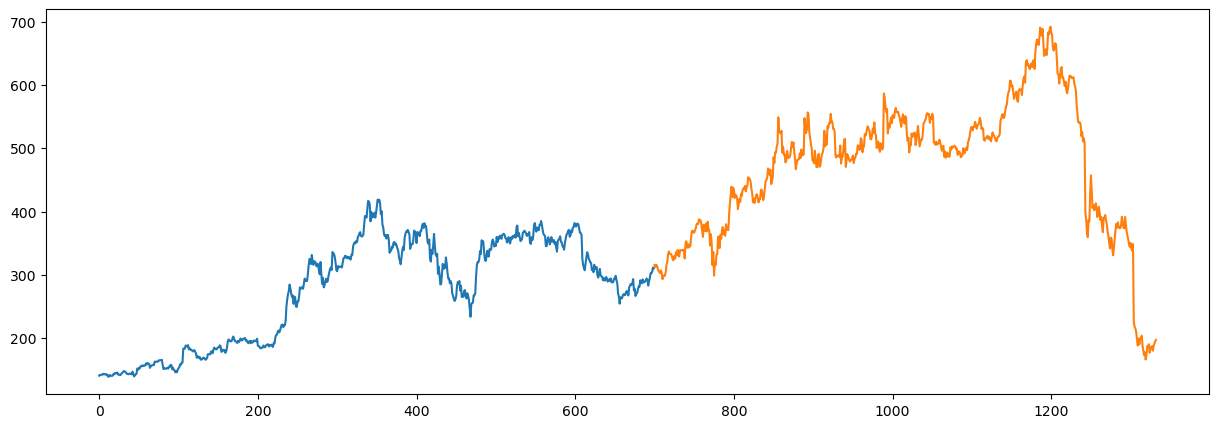

In [56]:
# View price behaviour
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,5)
df_train["Close_Price"].plot()
df_test["Close_Price"].plot()

In [57]:
# Initialise variables
MAX_INT = 2147483647
MAX_TRADES = 10000
MAX_OPEN_POSITIONS = 1
INITIAL_ACCOUNT_BALANCE = 1000
PERCENT_CAPITAL = 0.1
TRADING_COSTS_RATE = 0.001
KILL_THRESH = 0.4 # Threshold for balance preservation

In [58]:
# Structure environment
class StockTradingEnv(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}

    def __init__(self, df):
        super(StockTradingEnv, self).__init__()
        
        # Generic variables
        self.df = df
        
        # Account variables
        self.available_balance = INITIAL_ACCOUNT_BALANCE
        self.net_profit = 0
        
        # Position variables
        self.num_trades_long = 0
        self.num_trades_short = 0
        self.long_short_ratio = 0
        
        # Current Step
        self.current_step = 0
        self.lag = 20
        self.volatility = 1
        self.max_steps = len(df)

        # Actions of the format Long, Hold, Close
        self.action_space = spaces.Discrete(2)
        # Prices contains the Close and Close Returns etc
        self.observation_space = spaces.Box(low=-1, high=1, shape=(7, ), dtype=np.float32)
        
    # Calculate Reward
    def _calculate_reward(self):
        reward = 0
        reward += self.net_profit / self.volatility
        reward += 0.01 if self.long_short_ratio >= 0.3 and self.long_short_ratio <= 0.6 else -0.01
        return reward
    
    # Structure sign observation data
    def _next_observation(self):
        
        item_0_T0 = self.df.loc[self.current_step - 0, "Open"].item()
        item_1_T0 = self.df.loc[self.current_step - 0, "High"].item()       
        item_2_T0 = self.df.loc[self.current_step - 0, "Low"].item()
        item_3_T0 = self.df.loc[self.current_step - 0, "Close"].item()
        item_4_T0 = self.df.loc[self.current_step - 0, "Volume"].item()
        item_5_T0 = self.df.loc[self.current_step - 0, "sma_ease_of_movement"].item()
        
        env_4 = 1 if self.long_short_ratio else 0
        
        obs = np.array([item_0_T0, item_1_T0, item_2_T0, item_3_T0, item_4_T0, item_5_T0, env_4])
        
        return obs
    
    # Set the current price to a random price within the time step
    def _take_action(self, action):
        current_price = self.df.loc[self.current_step, "Close_Price"].item()
        next_price = self.df.loc[self.current_step + 1, "Close_Price"].item()
        next_return = next_price / current_price - 1
        
        # Go Long
        if action == 0:
            self.net_profit += self.available_balance * PERCENT_CAPITAL * next_return
            self.available_balance += self.net_profit
            self.num_trades_long += 1
                
        # Go Short
        if action == 1:
            self.net_profit += self.available_balance * PERCENT_CAPITAL * -next_return
            self.available_balance += self.net_profit
            self.num_trades_short += 1
        
        # Update metrics
        self.long_short_ratio = self.num_trades_long / (self.num_trades_long + self.num_trades_short)
        self.volatility = self.df.loc[self.current_step - self.lag, "Close_Price"].sum()

    # Execute one time step within the environment
    def step(self, action):
        self._take_action(action)

        reward = self._calculate_reward()
    
        self.current_step += 1
        
        is_max_steps_taken = self.current_step >= self.max_steps - self.lag - 1
        done = True if is_max_steps_taken else False
        
        obs = self._next_observation()

        return obs, reward, done, {}
    
    # Reset the state of the environment to an initial state
    def reset(self):
        self.available_balance = INITIAL_ACCOUNT_BALANCE
        self.net_profit = 0
        self.current_step = self.lag
        self.num_trades_long = 0
        self.num_trades_short = 0
        self.num_trades_ratio = 0

        return self._next_observation()

    # Render the environment to the screen
    def render(self, mode='human', close=False):
        pass

In [59]:
# Test Environment
env = StockTradingEnv(df_train)
actions = [0,1,2]
observation = env.reset()
print("Initial Observation: ", env.reset())

for action in actions:
    obs_, reward, done, info = env.step(action)
    print("")
    print("Action Taken: ", action)
    print("Reward Received : ", reward)
    print("Next State: ", obs_)
    print("Completed: ", done)
    print("-------------------")
    print("Available Balance: ", env.available_balance)
    print("Realized Profit: ", env.net_profit)
    print("Ratio: ", env.num_trades_ratio)
    print("-------------------")

Initial Observation:  [ 0.0587364   0.09344632  0.08415944  0.08535759  0.05292201 -0.00105433
  0.        ]

Action Taken:  0
Reward Received :  -0.01420453774741983
Next State:  [ 0.06055648  0.04080812  0.05387475 -0.0351294  -0.02175306 -0.00827923
  1.        ]
Completed:  False
-------------------
Available Balance:  999.4079169636134
Realized Profit:  -0.5920830363866147
Ratio:  0
-------------------

Action Taken:  1
Reward Received :  0.002335431927151373
Next State:  [-0.06693998 -0.03060853 -0.04431736  0.02958587  0.03497676 -0.00105232
  1.        ]
Completed:  False
-------------------
Available Balance:  998.3174788311427
Realized Profit:  -1.090438132470742
Ratio:  0
-------------------

Action Taken:  2
Reward Received :  0.0023213986715684897
Next State:  [ 0.06528213  0.02037078  0.0641383   0.02943907 -0.08463969  0.01021878
  1.        ]
Completed:  False
-------------------
Available Balance:  998.3174788311427
Realized Profit:  -1.090438132470742
Ratio:  0
------

In [60]:
class PPOMemory:
    def __init__(self, batch_size):
        self.states = []
        self.probs = []
        self.vals = []
        self.actions = []
        self.rewards = []
        self.dones = []

        self.batch_size = batch_size

    def generate_batches(self):
        n_states = len(self.states)
        batch_start = np.arange(0, n_states, self.batch_size)
        indices = np.arange(n_states, dtype=np.int64)
        np.random.shuffle(indices)
        batches = [indices[i:i+self.batch_size] for i in batch_start]

        return np.array(self.states),\
                np.array(self.actions),\
                np.array(self.probs),\
                np.array(self.vals),\
                np.array(self.rewards),\
                np.array(self.dones),\
                batches
    
    def store_memory(self, state, action, probs, vals, reward, done):
        self.states.append(state)
        self.actions.append(action)
        self.probs.append(probs)
        self.vals.append(vals)
        self.rewards.append(reward)
        self.dones.append(done)

    def clear_memory(self):
        self.states = []
        self.probs = []
        self.actions = []
        self.rewards = []
        self.dones = []
        self.vals = []

In [61]:
class ActorNetwork(nn.Module):
    def __init__(self, n_actions, input_dims, alpha,
            fc1_dims=256, fc2_dims=256, chkpt_dir='tmp/'):
        super(ActorNetwork, self).__init__()

        self.checkpoint_file = os.path.join(chkpt_dir, 'actor_torch_ppo') #Original V1 has some awesome weights
        self.actor = nn.Sequential(
                nn.Linear(*input_dims, fc1_dims),
                nn.ReLU(),
                nn.Linear(fc1_dims, fc2_dims),
                nn.ReLU(),
                nn.Linear(fc2_dims, n_actions),
                nn.Softmax(dim=-1)
        )

        self.optimizer = optim.AdamW(self.parameters(), lr=alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        dist = self.actor(state)
        dist = Categorical(dist)
        
        return dist

    def save_checkpoint(self):
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(T.load(self.checkpoint_file))

In [62]:
class CriticNetwork(nn.Module):
    def __init__(self, input_dims, alpha, fc1_dims=256, fc2_dims=256,
            chkpt_dir='tmp/'):
        super(CriticNetwork, self).__init__()

        self.checkpoint_file = os.path.join(chkpt_dir, 'critic_torch_ppo')
        self.critic = nn.Sequential(
                nn.Linear(*input_dims, fc1_dims),
                nn.ReLU(),
                nn.Linear(fc1_dims, fc2_dims),
                nn.ReLU(),
                nn.Linear(fc2_dims, 1)
        )

        self.optimizer = optim.AdamW(self.parameters(), lr=alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        value = self.critic(state)

        return value

    def save_checkpoint(self):
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(T.load(self.checkpoint_file))

In [63]:
class Agent:
    def __init__(self, n_actions, input_dims, gamma=0.99, alpha=0.0003, gae_lambda=0.95,
            policy_clip=0.2, batch_size=64, n_epochs=10):
        self.gamma = gamma
        self.policy_clip = policy_clip
        self.n_epochs = n_epochs
        self.gae_lambda = gae_lambda

        self.actor = ActorNetwork(n_actions, input_dims, alpha)
        self.critic = CriticNetwork(input_dims, alpha)
        self.memory = PPOMemory(batch_size)
       
    def remember(self, state, action, probs, vals, reward, done):
        self.memory.store_memory(state, action, probs, vals, reward, done)

    def save_models(self):
        print('... saving models ...')
        self.actor.save_checkpoint()
        self.critic.save_checkpoint()

    def load_models(self):
        print('... loading models ...')
        self.actor.load_checkpoint()
        self.critic.load_checkpoint()
        
    def choose_action(self, observation):
        state = T.tensor([observation], dtype=T.float).to(self.actor.device)
        state = state.flatten(0)

        dist = self.actor(state)
        value = self.critic(state)
        action = dist.sample()

        probs = T.squeeze(dist.log_prob(action)).item()
        action = T.squeeze(action).item()
        value = T.squeeze(value).item()

        return action, probs, value
    
    def learn(self):
        for _ in range(self.n_epochs):
            state_arr, action_arr, old_prob_arr, vals_arr,\
            reward_arr, dones_arr, batches = \
                    self.memory.generate_batches()

            values = vals_arr
            advantage = np.zeros(len(reward_arr), dtype=np.float32)
            
            # Calculate the advantage
            for t in range(len(reward_arr)-1):
                discount = 1
                a_t = 0
                for k in range(t, len(reward_arr)-1):
                    a_t += discount*(reward_arr[k] + self.gamma*values[k+1]*\
                            (1-int(dones_arr[k])) - values[k])
                    discount *= self.gamma*self.gae_lambda
                advantage[t] = a_t
            advantage = T.tensor(advantage).to(self.actor.device)
            
            values = T.tensor(values).to(self.actor.device)
            for batch in batches:
                states = T.tensor(state_arr[batch], dtype=T.float).to(self.actor.device)
                old_probs = T.tensor(old_prob_arr[batch]).to(self.actor.device)
                actions = T.tensor(action_arr[batch]).to(self.actor.device)

                dist = self.actor(states)
                critic_value = self.critic(states)

                critic_value = T.squeeze(critic_value)

                new_probs = dist.log_prob(actions)
                prob_ratio = new_probs.exp() / old_probs.exp()
                #prob_ratio = (new_probs - old_probs).exp()
                weighted_probs = advantage[batch] * prob_ratio
                weighted_clipped_probs = T.clamp(prob_ratio, 1-self.policy_clip,
                        1+self.policy_clip)*advantage[batch]
                actor_loss = -T.min(weighted_probs, weighted_clipped_probs).mean()

                returns = advantage[batch] + values[batch]
                critic_loss = (returns-critic_value)**2
                critic_loss = critic_loss.mean()

                total_loss = actor_loss + 0.5*critic_loss
                self.actor.optimizer.zero_grad()
                self.critic.optimizer.zero_grad()
                total_loss.backward()
                self.actor.optimizer.step()
                self.critic.optimizer.step()
                
            self.memory.clear_memory()

In [64]:
nv = StockTradingEnv(df_train)

batch_size = 5
n_epochs = 4
alpha = 0.0003

agent = Agent(n_actions=env.action_space.n, batch_size=batch_size, 
                alpha=alpha, n_epochs=n_epochs, 
                input_dims=env.observation_space.shape)

observation = env.reset()
action, prob, val = agent.choose_action(observation)
n_actions = env.action_space.n
print("Oberservation: ", observation)
print("Number of Actions: ", n_actions)
print("Action Chosen: ", action)
print("Probability of Action: ", prob)
print("Value of Action: ", val)

observation_, reward, done, info = env.step(action)
print("Next Oberservation", observation_)
print("Reward", reward)
print("Done", done)
print("Info", info)

Oberservation:  [ 0.0587364   0.09344632  0.08415944  0.08535759  0.05292201 -0.00105433
  1.        ]
Number of Actions:  2
Action Chosen:  0
Probability of Action:  -0.7319208979606628
Value of Action:  0.0017212964594364166
Next Oberservation [ 0.06055648  0.04080812  0.05387475 -0.0351294  -0.02175306 -0.00827923
  1.        ]
Reward -0.01420453774741983
Done False
Info {}


In [65]:
def plot_learning_curve(x, scores, figure_file):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-50):(i+1)])
    plt.plot(x, running_avg)
    plt.title('Running average of previous 50 scores')
    plt.savefig(figure_file)

... starting ...
... saving models ...
episide: 0, score: -35.74997516197534, avg score: -35.74997516197534, best_score: -35.74997516197534
... saving models ...
episide: 1, score: -33.49967586263758, avg score: -34.62482551230646, best_score: -34.62482551230646
... saving models ...
episide: 2, score: 217.76490176482432, avg score: 49.50508358007047, best_score: 49.50508358007047
... saving models ...
episide: 3, score: 88.46370348748944, avg score: 59.24473855692521, best_score: 59.24473855692521
episide: 4, score: 16.816736759827414, avg score: 50.759138197505656, best_score: 59.24473855692521
... saving models ...
episide: 5, score: 165.12996736962452, avg score: 69.82094305952546, best_score: 69.82094305952546
episide: 6, score: -47.00372500443908, avg score: 53.13170476467338, best_score: 69.82094305952546
episide: 7, score: 4.200527349334753, avg score: 47.015307587756055, best_score: 69.82094305952546
episide: 8, score: -4.9819768080859035, avg score: 41.237831543773616, best_s

episide: 79, score: 4.223082678557309, avg score: 117.94341554136588, best_score: 267.72920274083464
episide: 80, score: 137.79863752190906, avg score: 120.82752447791192, best_score: 267.72920274083464
episide: 81, score: 8.075772063438164, avg score: 123.92918775071476, best_score: 267.72920274083464
episide: 82, score: -50.424737655177715, avg score: 123.79993453948775, best_score: 267.72920274083464
episide: 83, score: 31.356599154496685, avg score: 123.54112758472611, best_score: 267.72920274083464
episide: 84, score: 23.794956578458986, avg score: 122.80931495583823, best_score: 267.72920274083464
episide: 85, score: 144.15357222866027, avg score: 107.13948793346528, best_score: 267.72920274083464
episide: 86, score: 12.948544178346586, avg score: 107.66495204185185, best_score: 267.72920274083464
episide: 87, score: -8.990352227318667, avg score: 117.42633196750987, best_score: 267.72920274083464
episide: 88, score: -16.264923781136396, avg score: 146.62590629373972, best_score:

episide: 159, score: -216.6525839441959, avg score: -341.0351134451988, best_score: 267.72920274083464
episide: 160, score: -0.1924664362697921, avg score: -341.2537839953629, best_score: 267.72920274083464
episide: 161, score: -34.31930241316126, avg score: -344.6790292457719, best_score: 267.72920274083464
episide: 162, score: 0.7122021866163637, avg score: -351.33110754609027, best_score: 267.72920274083464
episide: 163, score: -67.16639239490407, avg score: -362.55867117082687, best_score: 267.72920274083464
episide: 164, score: 41.824546576885744, avg score: -313.78808664718326, best_score: 267.72920274083464
episide: 165, score: 457.3548980837998, avg score: -307.3898713257224, best_score: 267.72920274083464
episide: 166, score: 21.279377715991217, avg score: -287.15486471847277, best_score: 267.72920274083464
episide: 167, score: -48.65308527593443, avg score: -288.44675752611494, best_score: 267.72920274083464
episide: 168, score: -19.997620280666162, avg score: -278.2003887953

episide: 239, score: -33.18283841779401, avg score: 26.867288676473578, best_score: 267.72920274083464
episide: 240, score: 826.1386125048483, avg score: 43.45680417574672, best_score: 267.72920274083464
episide: 241, score: 13.687656400970761, avg score: 44.60751735078873, best_score: 267.72920274083464
episide: 242, score: 18.848687199386664, avg score: 35.49576509608007, best_score: 267.72920274083464
episide: 243, score: -680.0230278207406, avg score: 9.583562828137866, best_score: 267.72920274083464
episide: 244, score: -26.40827209734978, avg score: 40.8441822872107, best_score: 267.72920274083464
episide: 245, score: -19.706521182619202, avg score: 36.05289261325147, best_score: 267.72920274083464
episide: 246, score: 53.98881707540212, avg score: 38.53152666087974, best_score: 267.72920274083464
episide: 247, score: -8.708527558396058, avg score: 38.7743654591438, best_score: 267.72920274083464
episide: 248, score: 70.77942120394074, avg score: 40.20408418037694, best_score: 26

episide: 319, score: -9.2808226568741, avg score: -21.490629323907033, best_score: 267.72920274083464
episide: 320, score: -8.394050745114514, avg score: -28.11877251934634, best_score: 267.72920274083464
episide: 321, score: 1552.1154556762997, avg score: 5.100704507250989, best_score: 267.72920274083464
episide: 322, score: 565.0697884018123, avg score: 17.20994145469816, best_score: 267.72920274083464
episide: 323, score: -12.184749126575841, avg score: 19.790514518859467, best_score: 267.72920274083464
episide: 324, score: -138.79910884149686, avg score: 18.342451764929955, best_score: 267.72920274083464
episide: 325, score: -46.04872531304498, avg score: 17.893317554189476, best_score: 267.72920274083464
episide: 326, score: -12.826591407234806, avg score: 18.2382060845867, best_score: 267.72920274083464
episide: 327, score: 59.829484674657195, avg score: 20.252107608308858, best_score: 267.72920274083464
episide: 328, score: 29.023542539279166, avg score: 21.20638770915831, best_

episide: 399, score: -166.93100257321169, avg score: -2.2936781652840903, best_score: 267.72920274083464
episide: 400, score: 5.36132481177399, avg score: -3.3061123378139046, best_score: 267.72920274083464
episide: 401, score: -853.7168024807403, avg score: -19.144752245460435, best_score: 267.72920274083464
episide: 402, score: -22.44569809978535, avg score: -20.582491360132284, best_score: 267.72920274083464
episide: 403, score: -2154.6350988137515, avg score: -64.68435491900682, best_score: 267.72920274083464
episide: 404, score: -8.125485829574812, avg score: -65.13964864352063, best_score: 267.72920274083464
episide: 405, score: -11.888717739017642, avg score: -65.4150631842266, best_score: 267.72920274083464
episide: 406, score: -839.2292793758289, avg score: -82.23658065715401, best_score: 267.72920274083464
episide: 407, score: -72.1482733059239, avg score: -85.66112963306466, best_score: 267.72920274083464
episide: 408, score: -1079.9345250484387, avg score: -107.132023715232

episide: 479, score: -190.58510912566317, avg score: 35.15231563833438, best_score: 267.72920274083464
episide: 480, score: 58.65867725905063, avg score: 35.251536304144594, best_score: 267.72920274083464
episide: 481, score: -67.04819241370376, avg score: 32.645702537720396, best_score: 267.72920274083464
episide: 482, score: -336.3849163359223, avg score: 26.208778484761762, best_score: 267.72920274083464
episide: 483, score: -31.436969869076172, avg score: 37.14679193359042, best_score: 267.72920274083464
episide: 484, score: -1488.8876654997866, avg score: 7.19841159478256, best_score: 267.72920274083464
episide: 485, score: -355.22582158114807, avg score: 0.41148677211553036, best_score: 267.72920274083464
episide: 486, score: 4727.025236446904, avg score: 95.0215903362425, best_score: 267.72920274083464
episide: 487, score: -1378.7249475658357, avg score: 60.22084705807672, best_score: 267.72920274083464
episide: 488, score: 253.60726380010925, avg score: 64.76945542839012, best_

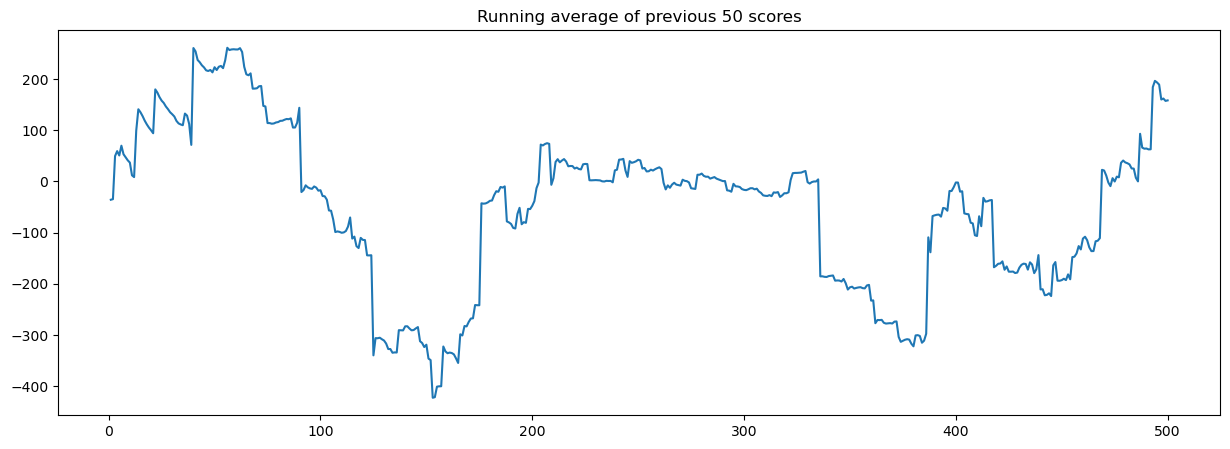

In [66]:
env = StockTradingEnv(df_train)
N = 20
batch_size = 5
n_epochs = 3
alpha = 0.0003
agent = Agent(n_actions=env.action_space.n, batch_size=batch_size, 
              alpha=alpha, n_epochs=n_epochs, 
              input_dims=env.observation_space.shape)

n_games = 500

figure_file = 'stock_training.png'

best_score = env.reward_range[0]
score_history = []

learn_iters = 0
avg_score = 0
n_steps = 0

print("... starting ...")
for i in range(n_games):
    observation = env.reset()
    done = False
    score = 0
    while not done:
        action, prob, val = agent.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        n_steps += 1
        score += reward
        agent.remember(observation, action, prob, val, reward, done)
        if n_steps % N == 0:
            agent.learn()
        observation = observation_
            
    # Save history
    score_history.append(score)
    avg_score = np.mean(score_history[-50:])
        
    if avg_score > best_score:
        best_score = avg_score
        agent.save_models()
        
    print(f"episide: {i}, score: {score}, avg score: {avg_score}, best_score: {best_score}")
            
x = [i+1 for i in range(len(score_history))]
plot_learning_curve(x, score_history, figure_file)

In [67]:
# agent.save_models()
n_actions = env.action_space.n
input_dims = env.observation_space.shape
alpha = 0.0003
model = ActorNetwork(n_actions, input_dims, alpha)
model.load_state_dict(T.load("tmp/actor_torch_ppo"))
model.eval()

ActorNetwork(
  (actor): Sequential(
    (0): Linear(in_features=7, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=2, bias=True)
    (5): Softmax(dim=-1)
  )
)

In [68]:
reporting_df = df_test.copy()
long_probs = []
short_probs = []
is_long = 1
is_short = 1
long_ratio = 0.5
for step in range(5, len(reporting_df)):

    item_0_T0 = df_mod.loc[step - 0, "Open"].item()
    item_1_T0 = df_mod.loc[step - 0, "High"].item()
    item_2_T0 = df_mod.loc[step - 0, "Low"].item()
    item_3_T0 = df_mod.loc[step - 0, "Close"].item()
    item_4_T0 = df_mod.loc[step - 0, "Volume"].item()
    item_5_T0 = df_mod.loc[step - 0, "sma_ease_of_movement"].item()
    
    obs = np.array([item_0_T0, item_1_T0, item_2_T0, item_3_T0, item_4_T0, item_5_T0, long_ratio])
    
    state = T.tensor(obs).float()
    dist = model(state)
    probs = dist.probs.detach().numpy()
    
    print(np.argmax(probs), probs)
    
    if action == 0:
        is_long += 1
    if action == 0:
        is_short += 1
    long_ratio = is_long / (is_long + is_short)

    long_probs.append(probs[0])
    short_probs.append(probs[1])

0 [0.5329666  0.46703336]
0 [0.53231925 0.4676808 ]
0 [0.5347962 0.4652038]
0 [0.5322885  0.46771148]
0 [0.53356653 0.46643353]
0 [0.5331021  0.46689788]
0 [0.53380245 0.4661976 ]
0 [0.53468144 0.46531853]
0 [0.5309617 0.4690383]
0 [0.5341894  0.46581063]
0 [0.5338277 0.4661723]
0 [0.53470016 0.46529987]
0 [0.53198826 0.46801177]
0 [0.5311857  0.46881434]
0 [0.53295815 0.46704185]
0 [0.53114545 0.46885458]
0 [0.53293425 0.46706572]
0 [0.5331777  0.46682233]
0 [0.5340491 0.4659509]
0 [0.53141147 0.46858853]
0 [0.535406   0.46459398]
0 [0.5348849  0.46511504]
0 [0.5332189  0.46678108]
0 [0.53233963 0.46766043]
0 [0.5326626 0.4673374]
0 [0.53276896 0.46723104]
0 [0.5317952  0.46820483]
0 [0.53323084 0.4667692 ]
0 [0.5335927  0.46640733]
0 [0.53385675 0.46614325]
0 [0.5340424 0.4659576]
0 [0.534845   0.46515507]
0 [0.53370404 0.46629596]
0 [0.53145456 0.46854544]
0 [0.5332594 0.4667406]
0 [0.5331373 0.4668627]
0 [0.53425115 0.46574888]
0 [0.5299756  0.47002444]
0 [0.53315276 0.46684724]
0 

In [69]:
capital = 1
perc_invest = 1
df_res = reporting_df.copy()
df_res = df_res[["Open", "Close_Price"]]
df_res["Returns"] = df_res["Close_Price"] / df_res["Close_Price"].shift(1) - 1
df_res = df_res.iloc[5:, :]
df_res["Longs"] = long_probs
df_res["Shorts"] = short_probs
df_res.loc[df_res["Longs"] >= 0.5, "DIR"] = df_res["Longs"]
df_res.loc[df_res["Longs"] < 0.5, "DIR"] = -df_res["Shorts"]
df_res = df_res.reset_index(drop=True)

equity = capital
equities = [capital]
for index, row in df_res.iterrows():
    if index > 0:
        dir_value = df_res.loc[index - 1, "DIR"].item()
        ret_value = df_res.loc[index, "Returns"].item()
        equity = equities[index - 1] + equities[index - 1] * perc_invest * dir_value * ret_value
        equities.append(equity)
        
df_res["Equity"] = equities
df_res["Benchmark"] = df_res["Returns"].cumsum() + 1
df_res.head()
df_res

,Open,Close_Price,Returns,Longs,Shorts,DIR,Equity,Benchmark
0,-0.260018,306.160004,-0.012355,0.532967,0.467033,0.532967,1.000000,0.987645
1,0.138022,304.320007,-0.006010,0.532319,0.467681,0.532319,0.996797,0.981635
2,-0.068820,302.859985,-0.004798,0.534796,0.465204,0.534796,0.994251,0.976837
3,-0.012542,307.350006,0.014825,0.532288,0.467711,0.532288,1.002134,0.991663
4,0.058419,302.500000,-0.015780,0.533567,0.466434,0.533567,0.993717,0.975883
...,...,...,...,...,...,...,...,...
623,-0.149750,180.339996,-0.037879,0.535378,0.464622,0.535378,0.821832,0.788490
624,-0.063480,187.830002,0.041533,0.535227,0.464773,0.535227,0.840106,0.830023
625,0.231380,191.399994,0.019007,0.533140,0.466860,0.533140,0.848652,0.849029
626,0.241324,195.190002,0.019802,0.532493,0.467507,0.532493,0.857612,0.868831


<Axes: >

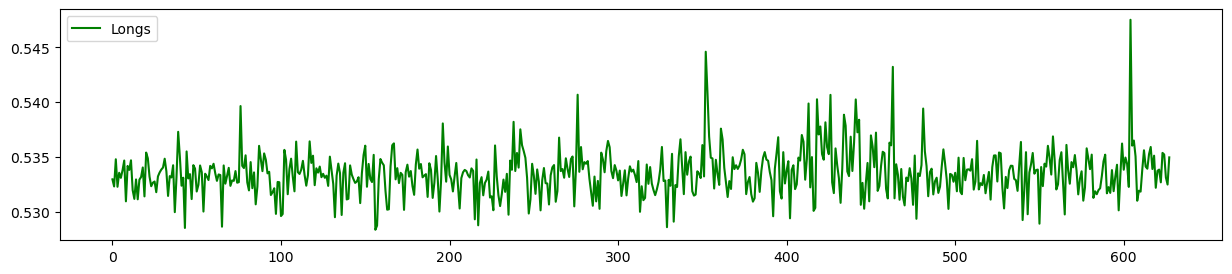

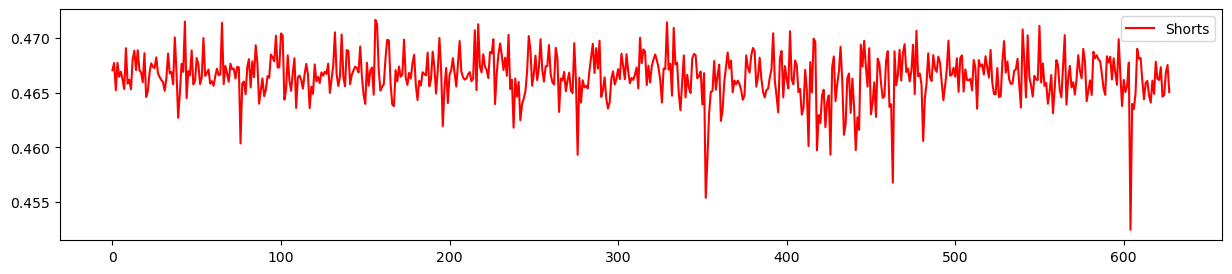

In [70]:
plt.rcParams["figure.figsize"] = (15,3)
df_res[["Longs"]].plot(color="green")
df_res[["Shorts"]].plot(color="red")

<Axes: >

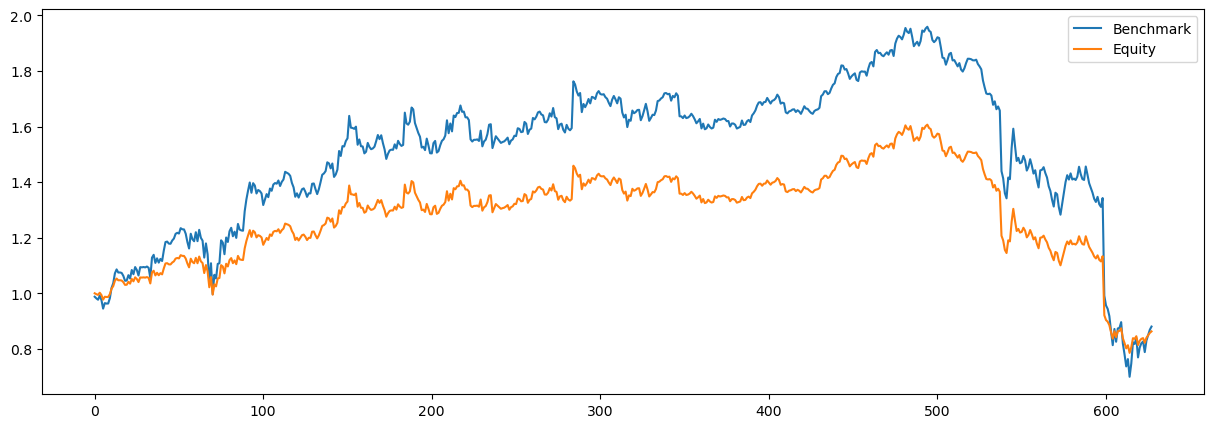

In [71]:
plt.rcParams["figure.figsize"] = (15,5)
df_res[["Benchmark", "Equity"]].plot()

In [72]:
# Metrics
Benchmark_Perc = (df_res["Close_Price"].iloc[-1] / df_res["Close_Price"].iloc[0] - 1) * 100
ROI_Perc = (df_res["Equity"].iloc[-1] / capital - 1) * 100
print(f"Benchmark Return {round(Benchmark_Perc, 2)}%")
print(f"ROI at {round(ROI_Perc, 2)}%")

Benchmark Return -35.51%
ROI at -13.71%
